# Image Super-Resolution for PET-CT Images


## Mount GDrive
remove if your file is not in gdrive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


## Import Libraries

In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.2 MB/s eta 0:00:00


In [3]:
import pydicom
import os
from pydicom import dcmread
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange

import numpy as np
import sys
import glob

## File Path 
path may differ by each individual

In [4]:
DIR_PATH = 'MyDrive/Dicom Data'
PATIENT_INDEX = [2,3,5,6,7,8,9,11,12,13,14,15,16,18,19,20,21]
nolabel_file_paths = {}
label_file_paths = {}
for pi in tqdm(PATIENT_INDEX):
    nlpath = f'{DIR_PATH}/Patient {pi}/nolabel'
    lpath = f'{DIR_PATH}/Patient {pi}/label'
    nolabel_path = []
    label_path = []
    for pic_folder in (os.listdir(nlpath)):
        for pic_name in os.listdir(f'{nlpath}/{pic_folder}'):
            nolabel_path.append(f'{nlpath}/{pic_folder}/{pic_name}')
    nolabel_file_paths[pi] = nolabel_path
    for pic_folder in (os.listdir(lpath)):
        for pic_name in os.listdir(f'{lpath}/{pic_folder}'):
            label_path.append(f'{lpath}/{pic_folder}/{pic_name}')
    label_file_paths[pi] = label_path

print(nolabel_file_paths[2][1:3])
print(label_file_paths[5][4:6])

  0%|          | 0/17 [00:00<?, ?it/s]

['MyDrive/Dicom Data/Patient 2/nolabel/Pet_021_18F_Fdg_Brain_Lm_(Adult)_P2002_20191003/IM-0001-0251.dcm', 'MyDrive/Dicom Data/Patient 2/nolabel/Pet_021_18F_Fdg_Brain_Lm_(Adult)_P2002_20191003/IM-0001-0217.dcm']
['MyDrive/Dicom Data/Patient 5/label/Pet_021_18F_Fdg_Brain_Lm_(Adult)_P2002_20200317/IM-0001-0004.dcm', 'MyDrive/Dicom Data/Patient 5/label/Pet_021_18F_Fdg_Brain_Lm_(Adult)_P2002_20200317/IM-0001-0070.dcm']


## Try pydicom Libratry

In [5]:
dcmdata = dcmread(label_path[58])
# for k,v in dcmdata.items():
#     print('*',k,'*',v,'*')

In [6]:
for element in dcmdata:
    print(element)

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.0.349.1643967979.703324
(0008, 0020) Study Date                          DA: '20180420'
(0008, 0021) Series Date                         DA: '20180420'
(0008, 0022) Acquisition Date                    DA: '20180420'
(0008, 0023) Content Date                        DA: '20180420'
(0008, 0030) Study Time                          TM: '101945'
(0008, 0031) Series Time                         TM: '104300.687000'
(0008, 0032) Acquisition Time                    TM: '104300.687000'
(0008, 0033) Content Time                        TM: '110049.000000'
(0008, 0050) Accession Number                    SH: '20180420NM0032'
(0008, 0060) Modality                            CS: 'PT'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'
(0008, 0080) Institut

In [7]:
label_path[59]

'MyDrive/Dicom Data/Patient 21/label/Pet_Brain_Scan_1_20180420/IM-0001-0141.dcm'

In [8]:
dcmdata.pixel_array.shape

(336, 336, 3)

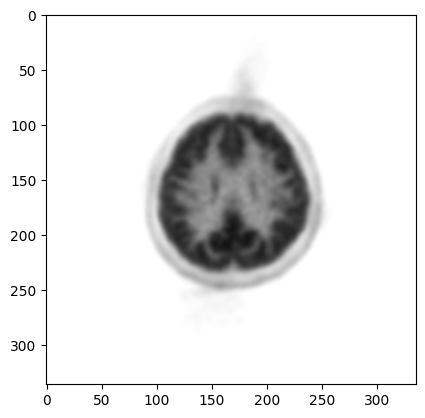

In [9]:
plt.imshow(dcmdata.pixel_array)
plt.show()

In [10]:
hasattr(dcmdata, 'SliceLocation')

True

In [11]:
dcmdata.SliceLocation

'888.5'

## Read Dicom

In [12]:
def read_dicom_of_patient(filespath,return_aspect = True):
    """
    Input
    filepaths: list of filepath to image of the same patient
    
    Output
    img3d: array of size (nslice,H,W,3) or (nslice,H,W)
    """
    print(f"file count: {len(filespath)}")
    # skip files with no SliceLocation (eg scout views)
    slices = []
    skipcount = 0
    for filename in tqdm(filespath):
        f = pydicom.dcmread(filename)
        if hasattr(f, 'SliceLocation'):
            slices.append(f)
        else:
            skipcount = skipcount + 1
    print(f"skipped, no SliceLocation: {skipcount}")

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.SliceLocation)

    # pixel aspects, assuming all slices are the same
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]

    # create 3D array
    img_shape = (len(slices),) + slices[0].pixel_array.shape
    img3d = np.zeros(img_shape)
    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = s.pixel_array
        img3d[i] = img2d

    return img3d.astype(np.uint8) , (ax_aspect,sag_aspect,cor_aspect)

def plot(img3d,aspects = (1,1,1)):
    img_shape = img3d.shape
    ax_aspect,sag_aspect,cor_aspect = aspects
    img3d = np.transpose(img3d,axes=(1,2,0,3))

    # plot 3 orthogonal slices
    a1 = plt.subplot(2, 2, 1)
    plt.imshow(img3d[:, :, img_shape[0]//2])
    a1.set_aspect(ax_aspect)

    a2 = plt.subplot(2, 2, 2)
    plt.imshow(img3d[:, img_shape[2]//2, :])
    a2.set_aspect(sag_aspect)

    a3 = plt.subplot(2, 2, 3)
    plt.imshow(np.transpose(img3d[img_shape[1]//2, :, :],axes=(1,0,2)))
    a3.set_aspect(cor_aspect)
    plt.show()

In [13]:
threedimage,aspect = read_dicom_of_patient(nolabel_file_paths[2])
threedimage.shape

file count: 175


  0%|          | 0/175 [00:00<?, ?it/s]

skipped, no SliceLocation: 0


(175, 440, 440, 3)

In [14]:
np.transpose(threedimage,axes=(1,2,0,3)).shape

(440, 440, 175, 3)

In [15]:
aspect

(1.0, 0.27499999999999997, 3.6363636363636367)

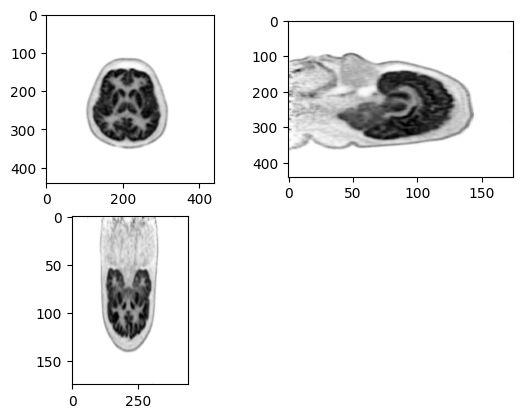

In [16]:
plot(threedimage,aspect)

## Generator

In [17]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch
import torch.nn as nn
from torchinfo import summary
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out
# generator = GeneratorResNet()

generator = GeneratorResNet(n_residual_blocks=32)
summary(generator)

Layer (type:depth-idx)                   Param #
GeneratorResNet                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       15,616
│    └─PReLU: 2-2                        1
├─Sequential: 1-2                        --
│    └─ResidualBlock: 2-3                --
│    │    └─Sequential: 3-1              74,113
│    └─ResidualBlock: 2-4                --
│    │    └─Sequential: 3-2              74,113
│    └─ResidualBlock: 2-5                --
│    │    └─Sequential: 3-3              74,113
│    └─ResidualBlock: 2-6                --
│    │    └─Sequential: 3-4              74,113
│    └─ResidualBlock: 2-7                --
│    │    └─Sequential: 3-5              74,113
│    └─ResidualBlock: 2-8                --
│    │    └─Sequential: 3-6              74,113
│    └─ResidualBlock: 2-9                --
│    │    └─Sequential: 3-7              74,113
│    └─ResidualBlock: 2-10               --
│    │    └─Sequential: 3-8             

### Load Model

In [19]:
state_dict_path = 'MyDrive/Weights/generator (4).pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# generator.load_state_dict(torch.load(state_dict_path))
generator.load_state_dict(torch.load(state_dict_path,map_location=device))

<All keys matched successfully>

## Pre Process

In [20]:
from torchvision import transforms

hr_height,hr_width = 336,336

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

lr_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((hr_height // 4, hr_width // 4)),
        # transforms.Normalize(mean, std),
    ]
)

## Pass input to Model

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


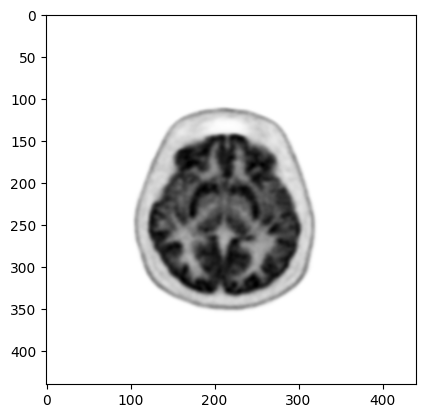

In [21]:
inp = threedimage[80]
input_image = lr_transform(inp)
if input_image.ndim == 3:
    input_image = torch.unsqueeze(input_image,0)
new_im = generator(input_image)

plt.imshow(inp)
plt.show()

In [22]:
new_im2 = np.transpose(new_im.squeeze().detach().numpy(),axes=(1,2,0))
m,M = new_im2.min(),new_im2.max()

new_im3 = (new_im2 - m)/(M-m)

## Results

### Raw Results

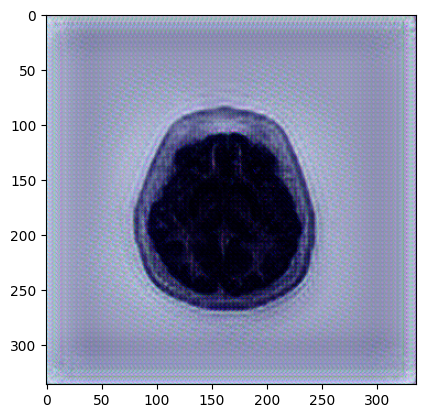

In [23]:
plt.imshow(new_im3)
plt.show()

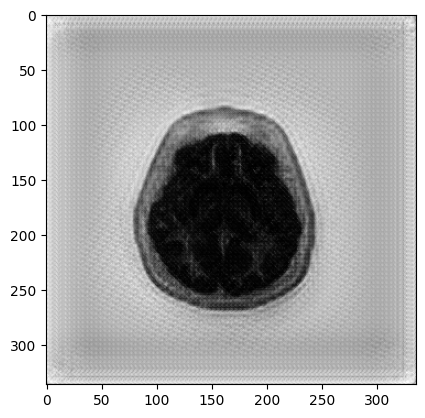

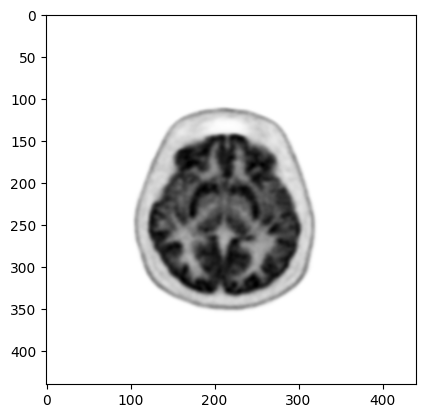

In [24]:
plt.imshow(new_im3.mean(axis = 2),cmap= 'gray')
plt.show()
plt.imshow(inp)
plt.show()

## Post Process

### Denoise with Fourier

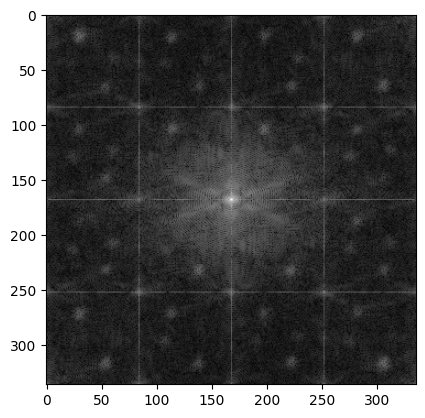

In [25]:
from scipy.fft import fft2,fftshift,ifftshift,ifft2
import cv2 
new_im4 = cv2.cvtColor(new_im3,cv2.COLOR_RGB2GRAY)

F = fft2(new_im4)
F = fftshift(F)

plt.imshow(np.log(1+ np.abs(F)),cmap = 'gray')
plt.show()


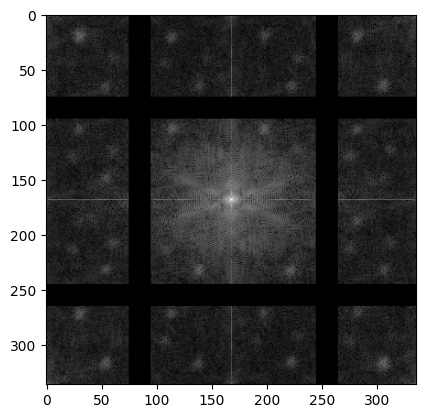

In [26]:
F2 = F.copy()
F2[75:95] = 0
F2[:,75:95] = 0

F2[245:265] = 0
F2[:,245:265] = 0

plt.imshow(np.log(1+ np.abs(F2)),cmap = 'gray')
plt.show()

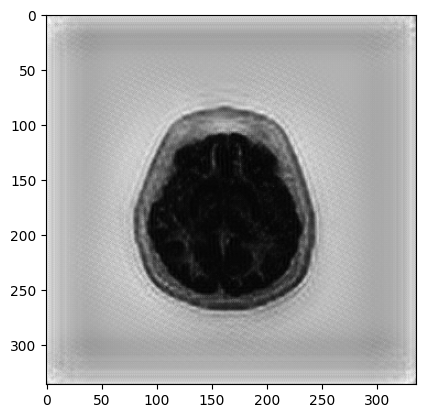

In [27]:
restore_im = np.real(ifft2(ifftshift(F2)))

plt.imshow(restore_im,cmap='gray')
plt.show()

### Rescale

In [28]:
def rescale_image_default(image):
    min_val,max_val = image.min(),image.max()
    
    return (image - min_val) / (max_val - min_val)

def image_dist(image):
    return image.mean((0,1)),image.std((0,1))

def rescale_image(image, target_mean, target_std):
    """
    Rescales an image to target mean and standard deviation for each color channel.

    Args:
        image (numpy.ndarray): Input image as a NumPy array.
        target_mean (tuple): Target mean values for each color channel (R, G, B).
        target_std (tuple): Target standard deviation values for each color channel (R, G, B).

    Returns:
        numpy.ndarray: Rescaled image as a NumPy array.
    """
    channel_means = np.mean(image, axis=(0, 1))  # Compute mean for each channel
    channel_stds = np.std(image, axis=(0, 1))  # Compute standard deviation for each channel
    rescaled_image = (image - channel_means) / channel_stds  # Standardize the image

    # Rescale each channel to the target mean and standard deviation
    for channel in range(3):  # Iterate over the three channels (R, G, B)
        rescaled_image[:, :, channel] = rescaled_image[:, :, channel] * target_std[channel] + target_mean[channel]

    return rescaled_image
    
def denoise_fourier(image):
    new_image = np.zeros_like(image)
    for i in range(3):
        image_chan = image[:,:,i]
        F = fft2(image_chan)
        F2 = fftshift(F)
        
        F2[80:90] = 0
        F2[:,80:90] = 0

        F2[250:260] = 0
        F2[:,250:260] = 0
        rest_chan = np.real(ifft2(ifftshift(F2)))
        new_image[:,:,i] = rest_chan
    return new_image
def to_gray(image):
    y = image.mean(axis = 2)
    return np.dstack((y,y,y))

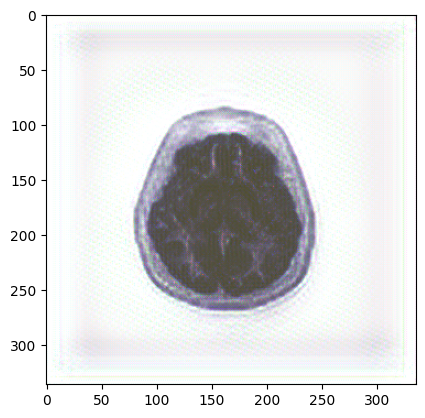

In [29]:
m,s = image_dist(inp / 255)
rsc_im = rescale_image(new_im2, m, s)
rsc_im = denoise_fourier(rsc_im)
rsc_im[rsc_im < 0] = 0
rsc_im[rsc_im > 1] = 1
plt.imshow(rsc_im)
plt.show()

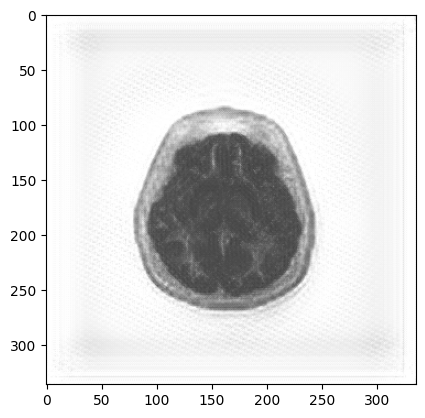

In [30]:
plt.imshow(to_gray(rsc_im))
plt.show()

In [31]:
rsc_im.min(),rsc_im.max()

(0.096322715, 1.0)

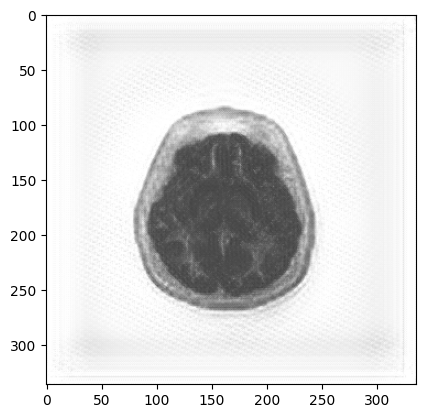

In [32]:
plt.imshow((to_gray(rsc_im) * 255).astype(np.uint8))
plt.show()

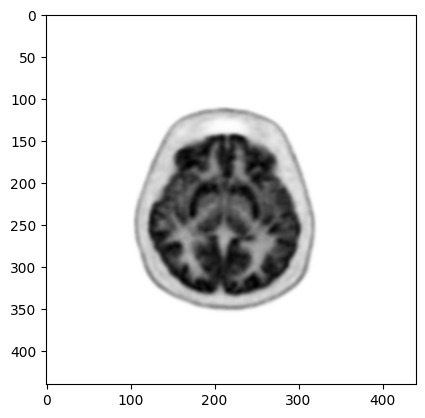

In [33]:
plt.imshow((inp)/255)
plt.show()

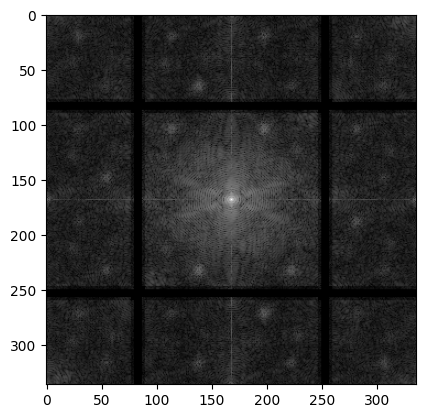

In [34]:
def spectrum(image,to_plot = True):
    gray = image.mean(axis = 2)
    F = fft2(gray)
    F = fftshift(F)
    if to_plot:
        return np.log(1+np.abs(F))
    return F
plt.imshow(spectrum(denoise_fourier(rsc_im)),cmap = 'gray')
plt.show()

## Full Pipeline

In [37]:
def modify_image(image,generator,gray = True,to_8_bytes = True):

    hr_height,hr_width = 336,336

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    lr_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((hr_height // 4, hr_width // 4)),
            # transforms.Normalize(mean, std),
        ]
    )

    input_image = lr_transform(image)
    if input_image.ndim == 3:
        input_image = torch.unsqueeze(input_image,0)
    new_im = generator(input_image)
    new_im2 = np.transpose(new_im.squeeze().detach().numpy(),axes=(1,2,0))
    m,s = image_dist(inp / 255)
    rsc_im = rescale_image(new_im2, m, s)
    rsc_im = denoise_fourier(rsc_im)
    rsc_im[rsc_im < 0] = 0
    rsc_im[rsc_im > 1] = 1
    if gray:
        rsc_im =  to_gray(rsc_im)
    # return rsc_im
    if to_8_bytes:
        rsc_im = (rsc_im * 255).astype(np.uint8)
    return rsc_im

def modify_dicom_file(input_file_path, output_file_path, image_modification_function):
    # Read the DICOM file
    dataset = pydicom.dcmread(input_file_path)
    
    # Get the pixel data
    pixel_data = dataset.pixel_array
    
    # Modify the pixel data using the provided image modification function
    pixel_data = image_modification_function(pixel_data)
    # cv2.imwrite(output_file_path[:-4]+'.png', pixel_data)
    # Update the pixel data in the DICOM dataset

    dataset.Rows = pixel_data.shape[1]
    dataset.Columns = pixel_data.shape[0]
    dataset.PixelData  = pixel_data.tobytes()

    


    # Save the modified DICOM dataset to a new file
    dataset.save_as(output_file_path)



def modify_multiple(patient_no, output_dir,generator):
    filenames = nolabel_file_paths[patient_no]
    modify_lamb = lambda x: modify_image(x,generator)
    if os.path.exists(output_dir):
        for x in os.listdir(output_dir):
            os.remove(output_dir +'/'+ x)
    else:
        os.mkdir(output_dir)
    for input_file_name in tqdm(filenames):
        output_name = f'{output_dir}/{os.path.basename(input_file_name)}'
        
        modify_dicom_file(input_file_name, output_name, modify_lamb)

In [38]:
for i in PATIENT_INDEX:
    print(f'Patient {i}')
    modify_multiple(2,f'../content/modified/Patient {i}',generator)

Patient 2


  0%|          | 0/175 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Patient 3


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 5


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 6


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 7


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 8


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 9


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 11


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 12


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 13


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 14


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 15


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 16


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 18


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 19


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 20


  0%|          | 0/175 [00:00<?, ?it/s]

Patient 21


  0%|          | 0/175 [00:00<?, ?it/s]

In [39]:
!pwd

/gdrive


In [40]:
!zip -r /content/modified.zip /content/modified

  adding: content/modified/ (stored 0%)
  adding: content/modified/Patient 5/ (stored 0%)
  adding: content/modified/Patient 5/IM-0001-0271.dcm (deflated 72%)
  adding: content/modified/Patient 5/IM-0001-0211.dcm (deflated 79%)
  adding: content/modified/Patient 5/IM-0001-0214.dcm (deflated 77%)
  adding: content/modified/Patient 5/IM-0001-0301.dcm (deflated 68%)
  adding: content/modified/Patient 5/IM-0001-0194.dcm (deflated 86%)
  adding: content/modified/Patient 5/IM-0001-0264.dcm (deflated 72%)
  adding: content/modified/Patient 5/IM-0001-0318.dcm (deflated 68%)
  adding: content/modified/Patient 5/IM-0001-0338.dcm (deflated 68%)
  adding: content/modified/Patient 5/IM-0001-0234.dcm (deflated 72%)
  adding: content/modified/Patient 5/IM-0001-0340.dcm (deflated 67%)
  adding: content/modified/Patient 5/IM-0001-0333.dcm (deflated 68%)
  adding: content/modified/Patient 5/IM-0001-0284.dcm (deflated 71%)
  adding: content/modified/Patient 5/IM-0001-0329.dcm (deflated 68%)
  adding: con

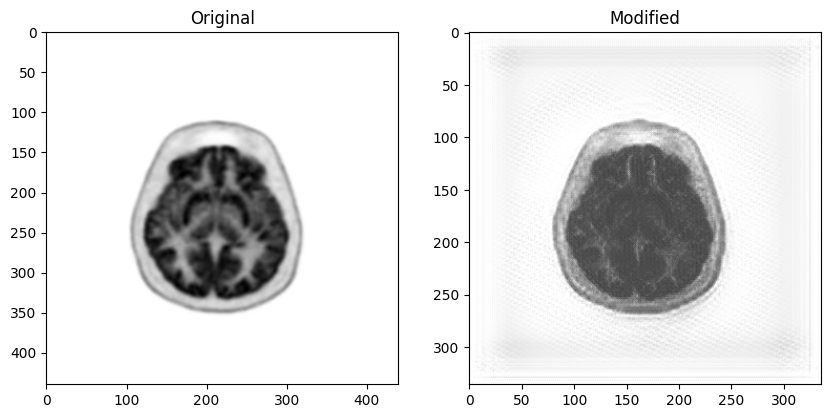

In [42]:
fig,ax = plt.subplots(1,2,figsize = (10,20))
modify_lamb = lambda x: modify_image(x,generator)
ax[0].imshow(threedimage[80])
ax[0].set_title('Original')
ax[1].imshow(modify_lamb(threedimage[80]))
ax[1].set_title('Modified')
plt.show()